In [ ]:
import json
import os
import glob
import re
from typing import Optional as Opt, Tuple, Union, List, Any
from PIL import Image
import cv2
import io
import base64
import numpy as np
import requests
import hashlib
import pandas as pd

from datetime import datetime
from dateutil import parser
import pytz

import uuid
import warnings

import pydicom
from pydicom.dataset import FileDataset as pydicomFileDataset, FileMetaDataset as pydicomFileMetaDataset
from pydicom import Dataset as pydicomDataset, Sequence, dcmread, dcmwrite
from pydicom.dataelem import DataElement
from pydicom.datadict import dictionary_VR, dictionary_has_tag
from pydicom.uid import UID as pydicomUID, generate_uid as generate_pydicomUID


from pyxnat import Interface, schema

from pathlib import Path, PurePosixPath

import shutil
import tempfile

from src.utilities import MetaTables, USCentralDateTime, XNATLogin, XNATConnection, ImageHash
from src.xnat_experiment_data import *
from src.xnat_scan_data import *
from src.xnat_resource_data import ORDataIntakeForm


validated_login = XNATLogin( login_info, verbose=verbose )
xnat_connection = XNATConnection( validated_login, stay_connected=True, verbose=verbose )
metatables = MetaTables( validated_login, xnat_connection, verbose=True )

-- Validated XNATLogin --
	User: dmattioli
	Server: https://rpacs.iibi.uiowa.edu/xnat/

-- XNAT Connection --
	Status:	Open
	User:	dmattioli
	Is Verified:	False
	Failed Tests:	['User is not added to project (XNAT-side)']
	Project:	<Project Object> GROK_AHRQ_Data `AHRQ-GROK Intraoperative Trauma and Arthroscopy Data` (private) 28 subjects  (owner: domattioli/stelong) (created on 2024-08-12 11:12:38.965) https://rpacs.iibi.uiowa.edu/xnat//data/projects/GROK_AHRQ_Data?format=html


AssertionError: Provided xnat_connection must be verified before accessing metatables: -- XNAT Connection --
	Status:	Open
	User:	dmattioli
	Is Verified:	False
	Failed Tests:	['User is not added to project (XNAT-side)']
	Project:	<Project Object> GROK_AHRQ_Data `AHRQ-GROK Intraoperative Trauma and Arthroscopy Data` (private) 28 subjects  (owner: domattioli/stelong) (created on 2024-08-12 11:12:38.965) https://rpacs.iibi.uiowa.edu/xnat//data/projects/GROK_AHRQ_Data?format=html

### SourceRFSession

In [101]:
ffn = r'R:\Anderson_Colaborations\AHRQ - 11287500\Fluoroscopy\Imported_Cases\DHS_20150130_1\DICOM\028_150110.dcm'
ffn = r'R:\Anderson_Colaborations\AHRQ - 11287500\Fluoroscopy\Imported_Cases\DHS_20210427_1\DICOM\213_100658.dcm'
dcm_data = pydicom.dcmread( ffn )
print( dcm_data )
ffn = r'R:\Anderson_Colaborations\AHRQ - 11287500\Fluoroscopy\Imported_Cases\DHS_20210427_1\DICOM\212_100657.dcm'
# ffn = r'R:\Anderson_Colaborations\AHRQ - 11287500\Fluoroscopy\Imported_Cases\DHS_20210427_1\DICOM\029_150110.dcm'
dcm_data = pydicom.dcmread( ffn )
print( dcm_data )

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 224
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: X-Ray Radiofluoroscopic Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.149015296310185424123997953873143279271
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.3.100.9.4
(0002, 0013) Implementation Version Name         SH: 'MATLAB IPT 9.4'
(0002, 0016) Source Application Entity Title     AE: 'RAP'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'SINGLE PLANE']
(0008, 0012) Instance Creation Date              DA: '20210608'
(0008, 0013) Instance Creation Time              TM:

difference = 0


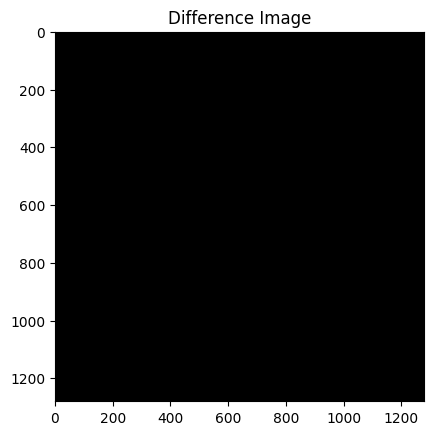

In [104]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the two images
image1_path = 'path_to_image1'
image1_path = r'R:\Anderson_Colaborations\AHRQ - 11287500\Fluoroscopy\Imported_Cases\DHS_20210427_1\DICOM\213_100658.dcm'
image2_path = r'R:\Anderson_Colaborations\AHRQ - 11287500\Fluoroscopy\Imported_Cases\DHS_20210427_1\DICOM\212_100657.dcm'

# Read in the dicom image from the two paths
image1 = pydicom.dcmread( image1_path ).pixel_array
image2 = pydicom.dcmread( image2_path ).pixel_array

# take the sum of squares of differences
diff = np.sum((image1 - image2) ** 2)
print( f'difference = {diff}' )

# Compute the absolute difference between the images
difference = cv2.absdiff(image1, image2)

# Display the difference
plt.imshow(difference, cmap='gray')
plt.title('Difference Image')
plt.show()

## Mass Upload - RF Session

In [92]:
import ast
def revise_string( in_string: str ) -> str:
    """Revise a string to replace all instances of spaces before and after apostrophes."""
    return re.sub( r'\'\s', '\'', re.sub(r'\s\'', '\'', in_string) )

def process_performer_hawkid_task( in_string: str, hawk_ids: dict, num_performers: int ) -> Tuple[Opt[str], List[str]]:
    """
    Process the Performer-HawkID_Task string to extract the relevant data.
    # 1. ensure the string is a valid python dictionary, 
    # 2. ensure the keys are valid HawkIDs, 
    # 3. replace any text within the values that contains the hawkids with their respective encoding, 
    # 4. return the dictionary.
    """
    # Check if the string is a valid python dictionary
    issues = []
    try:
        performer_hawkid_task = ast.literal_eval( revise_string( in_string ) )
        if not isinstance( performer_hawkid_task, dict ):
            print( 'hello')
            issues.append( f"\nWarning: Format of Performer-HawkID_Task must be in the following dict format '{{hawkid: task description, ..., hawkidN: task description N.}}'" )
    except:
        issues.append( f"\nError: Performer-HawkID_Task '{in_string}' is not a valid Python dictionary." )
        return None, issues
    
    # Colloborate the dictionary and check if the number of performers is correct.
    if len( performer_hawkid_task ) != num_performers:
        issues.append( f"\nError: Number of performers described in Performer-HawkID_Task ({len(performer_hawkid_task)}) does not match the expected number of performers ({num_performers}).")
        return None, issues
    
    # Check if each key in the dict is a valid HawkID, and replace it with its encoding.
    output_string = "{'"
    for key in performer_hawkid_task.keys():
        if key.lower() not in hawk_ids:
            output_string += ( f"{key}': '" )
            issues.append( f"\nWarning: HawkID '{key}' is not found in Registered_Users." ) # Should this be a fatal error? should we distinguish between an error and a fatal error? This is erroneous but its not a huge problem bc perfhaps this surgeon hasnt been registered with the system yet
        else: # Find where the key is in the string and replace it with the encoding.
            output_string += ( f"{hawk_ids[key.lower()]}': '" )
        
        # Check if any other hawk_ids are in the value text.
        value_text, issues_text = replace_hawkids_with_encodings( performer_hawkid_task[key], hawk_ids )  
        issues += issues_text
        output_string += value_text + "', '"
    output_string = output_string[:-3] + "}"
    return output_string, issues

def replace_hawkids_with_encodings( instring: str, hawkids: dict ) -> Tuple[str, List[str]]:
    """ Replace all instances of HawkIDs in a string with their respective encoding. """
    issues = []
    for k in hawkids:
        if k in instring:
            instring = instring.replace( k, 'HAWKID='+hawkids[k] )
            issues.append( f"\nWarning: HawkID '{k}' was found unencoded within the string, output will overwrite this." )    
    return instring, issues

test_str = "{ 'dmattioli': 'task1', 'jdoe': 'task2', 'jhill7': 'assisted dmattioli with stuff' }"
users = metatables.list_of_all_items_in_table( table_name='Registered_Users' )
users = {u.lower(): metatables.get_uid( table_name='Registered_Users', item_name=u ) for u in users}
result, issues = process_performer_hawkid_task( in_string=test_str, num_performers=3, hawk_ids=users )
print( test_str)
print( result )
print( issues )


{ 'dmattioli': 'task1', 'jdoe': 'task2', 'jhill7': 'assisted dmattioli with stuff' }
{'2_25_90458474139401388439508841677643557001': 'task1', 'jdoe': 'task2', '2_25_193478965827495767400532673438109218279': 'assisted HAWKID=2_25_90458474139401388439508841677643557001 with stuff'}
["\nWarning: HawkID 'jdoe' is not found in Registered_Users.", "\nWarning: HawkID 'dmattioli' was found unencoded within the string, output will overwrite this."]


In [ ]:
from datetime import datetime
import ast
import json

date_string = "1999-31-12"  # Example date string in format YYYY-DD-MM
date_format = "%Y-%d-%m"
date_to_check = datetime.strptime(date_string, date_format)


required_column_doc = r'C:\Users\dmattioli\Projects\XNAT-Interact\doc\Mass_Upload_Doc-Required_Columns.json'
def process_mass_upload_form( ffn: Path, verbose: bool = False ) -> Tuple[ pd.DataFrame, pd.DataFrame ]:
    """
    Process the mass upload form to extract the relevant data.
    """
    # Extract the file, format the column headers
    df = pd.read_excel( ffn, header=0 )
    df.columns = [col.replace('\n', ' ').strip().replace(' ', '_').lower() for col in df.columns]
    
    # Read the JSON file to get the column descriptions
    with open( required_column_doc, 'r' ) as file:
        column_descriptions = json.load(file)
    required_columns = [col for col, desc in column_descriptions.items() if 'required' in desc.lower()]
    required_columns = [col.replace(' ', '_').lower() for col in required_columns]
    conditional_columns = [col for col, desc in column_descriptions.items() if 'conditional' in desc.lower()]
    conditional_columns = [col.replace(' ', '_').lower() for col in conditional_columns]
    optional_columns = [col for col, desc in column_descriptions.items() if 'optional' in desc.lower()]
    optional_columns = [col.replace(' ', '_').lower() for col in optional_columns]

    # Check if the DataFrame contains all the required column names
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:     raise ValueError(f"The following required columns are missing: {', '.join(missing_columns)}")
    
    # Retrieve registed items from metatables config.
    hawk_ids = [id.lower() for id in metatables.list_of_all_items_in_table( table_name='Registered_Users' )]
    institutions = [i.lower() for i in metatables.list_of_all_items_in_table( table_name='Acquisition_Sites' )]
    procedure_names = [p.lower() for p in metatables.list_of_all_items_in_table( table_name='Groups' )]
    surgeon_hawkids = [s.lower() for s in metatables.list_of_all_items_in_table( table_name='Surgeons' )]
    surgeon_hawkid_encodings = {u.lower(): metatables.get_uid( table_name='Surgeons', item_name=u ) for u in surgeon_hawkids}
    
    # Iterate through each row, performing custom checks on all the columns
    issues = {}
    for idx, row in df.iterrows(): 
        if not row['Filer_Hawk_ID'] or row['Filer_Hawk_ID'].lower() not in hawk_ids:                                        # Required
            issues.setdefault( idx, [] ).append( f"Error: Filer_Hawk_ID '{row['Filer_Hawk_ID']}' not found in Registered_Users config table." )

        if not row['Operation_Date'] or datetime.strptime( row['Operation_Date'], date_format ) < datetime( 2000, 1, 1 ):   # Required
            issues.setdefault( idx, [] ).append( f"Warning: Operation_Date '{row['Operation_Date']}' is before January 1, 2000; make sure this is intentional." )

        if row['Quality'] in ['', ' ']:                                                                                     # Optional
            df.at[idx, 'Quality'] = 'Unknown'
            issues.setdefault( idx, [] ).append( f"Warning: Quality is blank, converting to 'Unknown'." )

        if not row['Institution'] or row['Institution'].lower() not in institutions:                                        # Required
            issues.setdefault( idx, [] ).append( f"Error: Institution '{row['Institution']}' not found in Acquisition_Sites config table." )

        if not row['Procedure_Name'] or row['Procedure_Name'].lower() not in procedure_names:                               # Required
            issues.setdefault( idx, [] ).append( f"Error: Procedure_Name '{row['Procedure_Name']}' not found in Groups." )

        if datetime.strptime( row['Epic_End_Time'], '%H:%M' ) < datetime.strptime( row['Epic_Start_Time'], '%H:%M' ):       # Optional
            issues.setdefault( idx, [] ).append( f"Error: Epic_End_Time '{row['Epic_End_Time']}' is before Epic_Start_Time '{row['Epic_Start_Time']}'." )

        if row['Supervising_Surgeon_Hawk_ID'] and row['Supervising_Surgeon'].lower() not in surgeon_hawkids:                # Optional
            issues.setdefault( idx, [] ).append( f"Error: Supervising_Surgeon '{row['Supervising_Surgeon']}' not found in Surgeons." )
            df.at[idx, 'Supervising_Surgeon_Hawk_ID'] = metatables.get_uid( table_name='Surgeons', item_name=row['Supervising_Surgeon'] )

        if row['Supervising_Surgeon_Hawk_ID'] and not row['Supervising_Surgeon_Presence']:                                  # Conditional
            issues.setdefault( idx, [] ).append( f"Error: Supervising_Surgeon_Presence should not be blank if Supervising_Surgeon is specified." )

        if not row['Performing_Surgeon_Hawk_ID'] or row['Performing_Surgeon_Hawk_ID'].lower() not in surgeon_hawkids:       # Required
            issues.setdefault( idx, [] ).append( f"Error: Performing_Surgeon_Hawk_ID '{row['Performing_Surgeon_Hawk_ID']}' not found in Registered_Users." )
            df.at[idx, 'Performing_Surgeon_Hawk_ID'] = metatables.get_uid( table_name='Surgeons', item_name=row['Performing_Surgeon_Hawk_ID'] )

        num_performers = int( row['#_of_Participating_Performing_Surgeons'] )                                               # Conditional 
        if num_performers > 1:                                               
            df.at[idx,'Performer_HawkID_Task'], item_issues = process_performer_hawkid_task( in_string=row['Performer_HawkID_Task'], num_performers=num_performers, hawk_ids=surgeon_hawkid_encodings )
            issues.setdefault( idx, [] ).extend( item_issues )
        
        if row['Unusual_Features'] not in ['', ' ']:                                                                        # Optional      
            df.at[idx, 'Unusual_Features'], col_issues = replace_hawkids_with_encodings( instring=row['Unusual_Features'], hawkids=surgeon_hawkid_encodings )
            issues.setdefault( idx, [] ).extend( col_issues )
        
        if row['Diagnostic_Notes'] not in ['', ' ']:                                                                        # Optional
            df.at[idx, 'Diagnostic_Notes'], col_issues = replace_hawkids_with_encodings( instring=row['Diagnostic_Notes'], hawkids=surgeon_hawkid_encodings )
            issues.setdefault( idx, [] ).extend( col_issues )
        
        if row['Additional_Comments'] not in ['', ' ']:                                                                     # Optional
            df.at[idx, 'Additional_Comments'], col_issues = replace_hawkids_with_encodings( instring=row['Additional_Comments'], hawkids=surgeon_hawkid_encodings )
            issues.setdefault( idx, [] ).extend( col_issues )
        
        if row['Skills_Assessment_Requested'] in ['', ' ']:                                                                 # Optional
            df.at[idx, 'Skills_Assessment_Requested'] = 'Unknown'
            issues.setdefault( idx, [] ).append( f"Warning: Skills_Assessment_Requested is blank, converting to 'Unknown'." )
        
        if row['Assessor_HawkID'] in ['', ' ']:                                                                             # Optional        
            df.at[idx, 'Assessor_HawkID'] = 'Unknown'
            issues.setdefault( idx, [] ).append( f"Warning: Assessor_HawkID is blank, converting to 'Unknown'." )
        else: # Cell is not empty
            if row['Assessor_HawkID'].lower() not in surgeon_hawkids:
                issues.setdefault( idx, [] ).append( f"Error: Assessor_HawkID '{row['Assessor_HawkID']}' not registered in Surgeons config table." )
            if row['Skills_Assessment_Requested'].lower() not in ['y']:
                issues.setdefault( idx, [] ).append( f"Error: Assessor_HawkID provided but Skills Assessment Requested not set to 'Y'." )
        
        if row['Additional_Assessment_Details'] not in ['', ' ']:                                                           # Optional
            df.at[idx, 'Additional_Assessment_Details'], col_issues = replace_hawkids_with_encodings( instring=row['Additional_Assessment_Details'], hawkids=surgeon_hawkid_encodings )
            issues.setdefault( idx, [] ).extend( col_issues )

        if row['Name/Type_of_Storage_Device'] in ['', ' ']:                                                                # Required
            issues.setdefault( idx, [] ).append( f"Error: Name/Type_of_Storage_Device cannot be blank." )
        
        if row['Full_Path_to_Data'] in ['', ' ']:                                                                           # Required
            issues.setdefault( idx, [] ).append( f"Error: Full_Path_to_Data cannot be blank." )
        elif not Path( row['Full_Path_to_Data'] ).exists():
            issues.setdefault( idx, [] ).append( f"Error: Full_Path_to_Data '{row['Full_Path_to_Data']}' does not exist." )

        if row['Was_Radiology_Contacted'] in ['', ' ']:                                                                     # Optional
            df.at[idx, 'Was_Radiology_Contacted'] = 'Unknown'
            issues.setdefault( idx, [] ).append( f"Warning: Was_Radiology_Contacted is blank, converting to 'Unknown'." )
        
        if row['Radiology_Contact_Date'] not in ['', ' ']:                                                                  # Optional
            # ensure that the text provided corresponds to a date
            try:
                datetime.strptime( row['Radiology_Contact_Date'], '%Y-%m-%d' )
            except:
                issues.setdefault( idx, [] ).append( f"Error: Radiology_Contact_Date '{row['Radiology_Contact_Date']}' is not a valid date." )
                
    return df

file_path = Path( r'C:\Users\dmattioli\Projects\XNAT-Interact\data\Mass_Upload_Template-trauma-to_delete.xlsx')
df = process_mass_upload_form( ffn=file_path, verbose=True )
# print( df.head())

### Structuring DHS Results

In [54]:
ffn = r'R:\Anderson_Colaborations\AHRQ - 11287500\Fluoroscopy\Imported_Cases\DHS_20140804_1\DICOM\DICOM_Results.json'

def parse_text_file(file_path):
    # Iterate over the lines and process each JSON object
    with open(file_path, 'r') as file:  lines = file.readlines()
    filenames, views, femoral_heads, femoral_necks, wires, sides, dicom_images = [], [], [], [], [], [], []
    for line in lines:
        line = line.strip()
        if line.startswith('{'):
            # Parse the JSON object
            data = json.loads(line)
            # Extract the required fields
            filenames.append(data.get('FileName', ''))
            views.append(data.get('View', ''))
            femoral_heads.append(data['Result'].get('Femoral_Head', ''))
            femoral_necks.append(data['Result'].get('Femoral_Neck', ''))
            wires.append(data['Result'].get('Wire', ''))
            sides.append(data.get('Side', ''))

            # dicom_file_path = Path(ffn).parent / f"{data.get('FileName', '')}.dcm"
            # try: # Read the DICOM file
            #     dicom_image = pydicom.dcmread(dicom_file_path).pixel_array
            #     dicom_images.append(dicom_image)
            # except Exception as e:
            #     dicom_images.append(None)
            #     print(f"Error reading DICOM file {dicom_file_path}: {e}")

    # Create a DataFrame with the extracted data
    df = pd.DataFrame({
        'filenames': filenames,
        'view': views,
        'femoral_head': femoral_heads,
        'femoral_neck': femoral_necks,
        'wire': wires,
        'side': sides#,
        # 'dicom_image': dicom_images
    })
    return df

df = parse_text_file(ffn)
print(df)

     filenames view                                       femoral_head  \
0   002_120821   AP  {'Left_XY': [476.88, 630.91], 'Top_XY': [668.1...   
1   008_120800   AP  {'Left_XY': [538.15, 491.7], 'Top_XY': [674.67...   
2   011_120834   AP  {'Left_XY': [539.28, 369.34], 'Top_XY': [694.5...   
3   038_130851   AP  {'Left_XY': [534.75, 309.29], 'Top_XY': [679.2...   
4   041_130833   AP  {'Left_XY': [541.55, 311.56], 'Top_XY': [688.8...   
5   047_130841   AP  {'Left_XY': [561.94, 309.86], 'Top_XY': [712.6...   
6   048_130827   AP  {'Left_XY': [567.61, 308.16], 'Top_XY': [708.6...   
7   050_130858   AP  {'Left_XY': [554.01, 311.56], 'Top_XY': [702.4...   
8   057_130822   AP  {'Left_XY': [566.47, 307.03], 'Top_XY': [705.8...   
9   068_130805   AP  {'Left_XY': [524.55, 314.39], 'Top_XY': [669.0...   
10  072_130812   AP  {'Left_XY': [528.64, 311.92], 'Top_XY': [687.6...   
11  093_130848   AP  {'Left_XY': [531.35, 322.89], 'Top_XY': [673.5...   
12  101_130824   AP  {'Left_XY': [488.

In [110]:
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import generate_uid, ExplicitVRLittleEndian
from pydicom.sequence import Sequence
from datetime import datetime
from pathlib import Path
import pydicom

def create_dicom_sr(features, accession_number, graphic_type, text_value, fn, series_num, instance_num, output_path):
    # Create a dummy evidence item with required attributes
    dummy_evidence = Dataset()
    dummy_evidence.PatientID = 'REDACTED' # Required
    dummy_evidence.PatientName = 'REDACTED' # Required
    dummy_evidence.PatientBirthDate = 'REDACTED' # Required
    dummy_evidence.PatientSex = 'O'  # Required
    dummy_evidence.AccessionNumber = accession_number  # Required
    dummy_evidence.StudyInstanceUID = generate_uid()
    dummy_evidence.SeriesInstanceUID = generate_uid()
    dummy_evidence.SOPInstanceUID = generate_uid()

    # Add each geometric feature as a content item
    content_items = []
    for feature in features:
        scoord_item = Dataset()
        scoord_item.ValueType = 'SCOORD' # SCOORD = Spatial Coordinates
        scoord_item.GraphicType = graphic_type # Possibles options: 'POINT', 'POLYLINE', 'MULTIPOINT', 'POLYGON', 'CIRCLE', 'ELLIPSE'
        # Flatten the list of points
        scoord_item.GraphicData = [coord for point in feature["points"] for coord in point]
        scoord_item.ConceptNameCodeSequence = Sequence([Dataset()])
        scoord_item.ConceptNameCodeSequence[0].CodeValue = 'T-D0050'
        scoord_item.ConceptNameCodeSequence[0].CodingSchemeDesignator = 'SRT'
        scoord_item.ConceptNameCodeSequence[0].CodeMeaning = feature["label"]
        content_items.append(scoord_item)

    # Add a textual description explaining what the points correspond to
    text_item = Dataset()
    text_item.ValueType = 'TEXT'
    text_item.TextValue = text_value
    text_item.ConceptNameCodeSequence = Sequence([Dataset()])
    text_item.ConceptNameCodeSequence[0].CodeValue = '121071'
    text_item.ConceptNameCodeSequence[0].CodingSchemeDesignator = 'DCM'
    text_item.ConceptNameCodeSequence[0].CodeMeaning = 'Textual description'
    content_items.append(text_item)

    # Add a container to provide context about the geometric features
    container_item = Dataset()
    container_item.ValueType = 'CONTAINER'
    container_item.ContinuityOfContent = 'SEPARATE'
    container_item.ConceptNameCodeSequence = Sequence([Dataset()])
    container_item.ConceptNameCodeSequence[0].CodeValue = 'T-D0050'
    container_item.ConceptNameCodeSequence[0].CodingSchemeDesignator = 'SRT'
    container_item.ConceptNameCodeSequence[0].CodeMeaning = "Measurement"
    container_item.ContentSequence = Sequence(content_items)

    # Create the DICOM SR dataset
    file_meta = Dataset()
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.88.11'  # Comprehensive SR Storage
    file_meta.MediaStorageSOPInstanceUID = generate_uid()
    file_meta.TransferSyntaxUID = ExplicitVRLittleEndian
    file_meta.ImplementationClassUID = generate_uid()

    ds = FileDataset(fn, {}, file_meta=file_meta, preamble=b"\0" * 128)
    ds.is_little_endian = True
    ds.is_implicit_VR = False

    # Populate the dataset with required attributes
    ds.PatientID = dummy_evidence.PatientID
    ds.PatientName = dummy_evidence.PatientName
    ds.PatientBirthDate = dummy_evidence.PatientBirthDate
    ds.PatientSex = dummy_evidence.PatientSex
    ds.StudyInstanceUID = dummy_evidence.StudyInstanceUID
    ds.SeriesInstanceUID = dummy_evidence.SeriesInstanceUID
    ds.SOPInstanceUID = dummy_evidence.SOPInstanceUID
    ds.Modality = 'SR' # "Structured Report"
    ds.SeriesNumber = series_num
    ds.InstanceNumber = instance_num
    ds.CompletionFlag = 'COMPLETE'
    ds.VerificationFlag = 'UNVERIFIED'
    ds.ContentDate = datetime.now().strftime('%Y%m%d')
    ds.ContentTime = datetime.now().strftime('%H%M%S')
    ds.ConceptNameCodeSequence = Sequence([Dataset()])
    ds.ConceptNameCodeSequence[0].CodeValue = 'P5-09051'
    ds.ConceptNameCodeSequence[0].CodingSchemeDesignator = 'SRT'
    ds.ConceptNameCodeSequence[0].CodeMeaning = 'Measurement'
    ds.ContentSequence = Sequence([container_item])

    # Save the SR to a DICOM file
    output_path = Path(output_path)
    ds.save_as(output_path / fn)

    print(f"DICOM SR saved to {output_path / fn}")

    # Load the saved dicom sr
    ds = pydicom.dcmread(output_path / fn)
    print(ds)

# Example usage
features = [
    {"points": [(30, 40)], "label": "TopXY"},
    {"points": [(10, 20)], "label": "LeftCY"},
    {"points": [(5, 5)], "label": "CenterXY"}
]
accession_number = 'REDACTED'
graphic_type = 'ELLIPSE'
text_value = 'The points correspond to the top, left, and center vertices from which the ellipse is derived.'
fn = 'test.dcm'
series_num = 1
instance_num = 1
output_path = r'C:\Users\dmattioli\OneDrive - University of Iowa\Downloads\tmp'


In [153]:
import pandas as pd
from pydicom.uid import generate_uid

# Assuming df is your DataFrame
# df = pd.read_csv('your_dataframe.csv')  # Example of loading a DataFrame

def create_dicom_sr(features, accession_number, graphic_type, text_value, fn, series_num, instance_num, output_path):
    from pydicom.dataset import Dataset, FileDataset
    from pydicom.sequence import Sequence
    from datetime import datetime
    from pathlib import Path
    import pydicom

    # Create a dummy evidence item with required attributes
    dummy_evidence = Dataset()
    dummy_evidence.PatientID = 'REDACTED' # Required
    dummy_evidence.PatientName = 'REDACTED' # Required
    dummy_evidence.PatientBirthDate = '19000101' # Required
    dummy_evidence.PatientSex = 'O'  # Required
    dummy_evidence.AccessionNumber = accession_number  # Required
    dummy_evidence.StudyInstanceUID = accession_number  # ***Should we do anything unique with these?***
    dummy_evidence.SeriesInstanceUID = accession_number # ***Should we do anything unique with these?***
    dummy_evidence.SOPInstanceUID = generate_uid()

    # Add each geometric feature as a content item
    content_items = []
    for feature, g_type, t_value in zip(features, graphic_type, text_value):
        scoord_item = Dataset()
        scoord_item.ValueType = 'SCOORD' # SCOORD = Spatial Coordinates
        scoord_item.GraphicType = g_type # Possibles options: 'POINT', 'POLYLINE', 'MULTIPOINT', 'POLYGON', 'CIRCLE', 'ELLIPSE'
        # Flatten the list of points and convert to float
        try:
            scoord_item.GraphicData = [float(coord) for point in feature["points"] for coord in point]
        except ValueError as e:
            print(f"Error converting points to float: {e}")
            print(f"Feature: {feature}")
            continue  # Skip this feature if there is an error
        scoord_item.ConceptNameCodeSequence = Sequence([Dataset()])
        scoord_item.ConceptNameCodeSequence[0].CodeValue = 'T-D0050'
        scoord_item.ConceptNameCodeSequence[0].CodingSchemeDesignator = 'SRT'
        scoord_item.ConceptNameCodeSequence[0].CodeMeaning = feature["label"]
        content_items.append(scoord_item)

    # Add a textual description explaining what the points correspond to
    text_item = Dataset()
    text_item.ValueType = 'TEXT'
    text_item.TextValue = 'test'  # Assuming the first text value is the description
    text_item.ConceptNameCodeSequence = Sequence([Dataset()])
    text_item.ConceptNameCodeSequence[0].CodeValue = '121071'
    text_item.ConceptNameCodeSequence[0].CodingSchemeDesignator = 'DCM'
    text_item.ConceptNameCodeSequence[0].CodeMeaning = 'Textual description'
    text_item.add_new(0x0040A160, 'UT', text_value )  # Use UT VR for unlimited text
    content_items.append(text_item)

    # Add a container to provide context about the geometric features
    container_item = Dataset()
    container_item.ValueType = 'CONTAINER'
    container_item.ContinuityOfContent = 'SEPARATE'
    container_item.ConceptNameCodeSequence = Sequence([Dataset()])
    container_item.ConceptNameCodeSequence[0].CodeValue = 'T-D0050'
    container_item.ConceptNameCodeSequence[0].CodingSchemeDesignator = 'SRT'
    container_item.ConceptNameCodeSequence[0].CodeMeaning = "Measurement"
    container_item.ContentSequence = Sequence(content_items)

    # Create the DICOM SR dataset
    file_meta = Dataset()
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.88.11'  # Comprehensive SR Storage
    file_meta.MediaStorageSOPInstanceUID = generate_uid()
    file_meta.TransferSyntaxUID = ExplicitVRLittleEndian
    file_meta.ImplementationClassUID = generate_uid()

    ds = FileDataset(fn, {}, file_meta=file_meta, preamble=b"\0" * 128)
    ds.is_little_endian = True
    ds.is_implicit_VR = False

    # Populate the dataset with required attributes
    ds.PatientID = dummy_evidence.PatientID
    ds.PatientName = dummy_evidence.PatientName
    ds.PatientBirthDate = dummy_evidence.PatientBirthDate
    ds.PatientSex = dummy_evidence.PatientSex
    ds.StudyInstanceUID = dummy_evidence.StudyInstanceUID
    ds.SeriesInstanceUID = dummy_evidence.SeriesInstanceUID
    ds.SOPInstanceUID = dummy_evidence.SOPInstanceUID
    ds.Modality = 'SR' # "Structured Report"
    ds.SeriesNumber = series_num
    ds.InstanceNumber = instance_num
    ds.CompletionFlag = 'COMPLETE'
    ds.VerificationFlag = 'UNVERIFIED'
    ds.ContentDate = datetime.now().strftime('%Y%m%d')
    ds.ContentTime = datetime.now().strftime('%H%M%S')
    ds.ConceptNameCodeSequence = Sequence([Dataset()])
    ds.ConceptNameCodeSequence[0].CodeValue = 'P5-09051'
    ds.ConceptNameCodeSequence[0].CodingSchemeDesignator = 'SRT'
    ds.ConceptNameCodeSequence[0].CodeMeaning = 'Measurement'
    ds.ContentSequence = Sequence([container_item])

    # Save the SR to a DICOM file
    output_path = Path(output_path)
    ds.save_as(output_path / fn)
    return ds


output_path = r'C:\Users\dmattioli\OneDrive - University of Iowa\Downloads\tmp'
accession_number = generate_uid()
output_path = Path(output_path) / str( accession_number ).replace('.', '_')
os.mkdir( output_path )
series_num = 1  # Use the row index + 1 as a unique integer for SeriesNumber
print( f'FolderName: {accession_number}' )
for index, row in df.iterrows():
    femoral_head_xy = [[float(coord) for coord in v] for v in row['femoral_head'].values()]
    
    # if row['wire']['XY'] is not empty
    if len(row['wire']['XY']) > 0: wire_info = [[float(coord) for coord in v] for v in row['wire']['XY']]
    else:                   wire_info = [[np.nan]]
    features = [
        {"points": femoral_head_xy, "label": "Femoral Head"},
        {"points": row['femoral_neck'], "label": "Femoral Neck"},
        {"points": wire_info, "label": "Wire"}
    ]
    graphic_type = ['ELLIPSE', 'LINE', 'LINE']
    text_value = ['3 defining points of ellipse; [leftx1 lefty1 topx1 topy1 centerx1 centery1]', 'Femoral neck bisector; [x1 y1 x2 y2]', 'Wire info; [entryx1 entryy1 tipx2 tipy2 pixelwidth mmwidth]']
    fn = row['filenames']
    instance_num = int(fn[:3])  # Convert the first 3 characters of the filename to an integer
    
    ds = create_dicom_sr(features, accession_number, graphic_type, text_value, fn, series_num, instance_num, output_path)

    print( f'\nFile: {fn} ')
    print( ds )

FolderName: 1.2.826.0.1.3680043.8.498.66902964531829963427179279246854874276

File: 002_120821 
Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Basic Text SR Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.93295463020334009840666896674517758163
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.40619703683525919336390786452349124153
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.31824358247363462966997595342338193012
(0008, 0023) Content Date                        DA: '20241015'
(0008, 0033) Content Time                        TM: '135611'
(0008, 0060) Modality                            CS: 'SR'
(0010, 0010) Patient's Name                      PN: 'REDACTED'
(0010, 0020) Patient ID                         

In [100]:
def print_preview_of_xnat_data( pd_table ):
    print( f'# Performances: {len(pd_table)}' )

    # Columns to display: procedure operation_date upload_date upload_time
    pd_copy = pd_table.copy()
    pd_copy.index = pd_copy.index + 1
    pd_copy['upload_time'] = pd_copy['upload_time'].apply(lambda x: x.strftime('%H:%M'))
    print( pd_copy[['procedure', 'operation_date', 'upload_date', 'upload_time']] )

In [105]:
# xnat:subjectData/GROUP
# xnat:experimentData/ACQUISITION_SITE
# xnat:experimentData/DATE

# user_prompt = input( 'Please select a procedure that you want to query:')
user_prompt = 'KNEE_ARTHROSCOPY-PRE_DIAGNOSTIC'
constraints =  [('xnat:subjectData/PROJECT', '=', 'GROK_AHRQ_Data'),
                'AND',
                ('xnat:subjectData/GROUP' , '=', user_prompt )
                ]


user_date_range = ['2021-11-01', '2024-12-31']

# Query all experiments --> note that we can specify esv v rf if we want. We could also query derived data. Not sure how to separate them if we query all at once without doing another query. Perpahs you do separate queries and the combine the tables.
constraints =  [('xnat:esvSessionData/PROJECT', '=', 'GROK_AHRQ_Data'),
                'OR',
                ('xnat:rfSessionData/PROJECT' , '=', 'GROK_AHRQ_Data' )]
with Interface( server='https://rpacs.iibi.uiowa.edu/xnat', user='dmattioli', password='PooPoopoopoo123$' ) as xnat:
    # Get all experiments.
    all_data = xnat.select('xnat:esvSessionData').where(constraints)
    all_data_pd = format_as_table( all_data )

    # Remove some dumb columns
    cols_to_remove = ['age', 'project']
    all_data_pd.drop( columns=cols_to_remove, inplace=True )

    # rename 'date' to 'operation_date'
    all_data_pd.rename(columns={'date': 'operation_date'}, inplace=True)


    # Perform query that retrieves the subject names
    new_constraints =  [('xnat:subjectData/PROJECT', '=', 'GROK_AHRQ_Data'), 'AND']
    sub_constraints = []
    subject_ids = all_data_pd['subject_id'].unique()
    for i, subject_id in enumerate(subject_ids):
        if i > 0:
            sub_constraints.append('OR')
        sub_constraints.append( ('xnat:subjectData/SUBJECT_ID', '=', subject_id) )
    new_constraints.append( sub_constraints )
    subj_qs = xnat.select('xnat:subjectData').where(new_constraints)
    subj_pd = format_as_table( subj_qs )
    cols_to_remove = ['gender_text', 'handedness_text', 'dob', 'educ', 'add_ids', 'race', 'ethnicity', 'invest_csv', 'ses', 'projects']
    subj_pd.drop( columns=cols_to_remove, inplace=True )

    # Append the following columns of subj_pd to all_data_pd: 'sub_group', 'xnat_col_subjectdatalabel'
    all_data_pd = all_data_pd.reset_index(drop=True)
    subj_pd = subj_pd.reset_index(drop=True)

    # Append the 'sub_group' and 'xnat_col_subjectdatalabel' columns from subj_pd to all_data_pd
    all_data_pd['procedure'] = subj_pd['sub_group']
    all_data_pd['subject_id'] = subj_pd['xnat_col_subjectdatalabel']
    # all_data_pd.drop( columns=['subject_id', 'expt_id'], inplace=True )

    # # Split insert_date into two columns
    all_data_pd['insert_date'] = pd.to_datetime(all_data_pd['insert_date'])
    all_data_pd['upload_date'] = all_data_pd['insert_date'].dt.date
    all_data_pd['upload_time'] = all_data_pd['insert_date'].dt.time
    all_data_pd.drop( columns=['insert_date'], inplace=True )
    print_preview_of_xnat_data( all_data_pd )

    # Ask the user if they want to filter by date
    user_date_filter = '1'
    if user_date_filter == '1':
        # Filter by date
        start_date = '2021-11-01'
        end_date = '2024-12-31'
        all_data_pd['operation_date'] = pd.to_datetime(all_data_pd['operation_date'])
        all_data_pd = all_data_pd[ ( all_data_pd['operation_date'] >= start_date ) & ( all_data_pd['operation_date'] <= end_date ) ]
        print_preview_of_xnat_data( all_data_pd )

    # ask the user if they want to filter by procedure
    user_procedure_filter = '1'
    if user_procedure_filter == '1':
        # Filter by procedure
        user_procedure = 'KNEE_ARTHROSCOPY-PRE_DIAGNOSTIC'
        all_data_pd = all_data_pd[ all_data_pd['procedure'] == user_procedure ]
        print_preview_of_xnat_data( all_data_pd )


<class 'pyxnat.core.jsonutil.JsonTable'>
<class 'pyxnat.core.jsonutil.JsonTable'>
# Performances: 24
                               procedure operation_date upload_date  \
1        KNEE_ARTHROSCOPY-PRE-DIAGNOSTIC     2021-07-14  2024-08-28   
2       KNEE_ARTHROSCOPY-POST_DIAGNOSTIC     2021-12-30  2024-08-28   
3        KNEE_ARTHROSCOPY-PRE-DIAGNOSTIC     2021-11-10  2024-08-28   
4       KNEE_ARTHROSCOPY-POST_DIAGNOSTIC     2021-02-22  2024-08-28   
5       KNEE_ARTHROSCOPY-POST_DIAGNOSTIC     2021-10-19  2024-08-28   
6        KNEE_ARTHROSCOPY-PRE-DIAGNOSTIC     2021-09-03  2024-08-28   
7   KNEE_ARTHROSCOPY-MENISCAL_TRANSPLANT     2021-09-07  2024-08-28   
8        KNEE_ARTHROSCOPY-PRE-DIAGNOSTIC     2023-11-21  2024-08-28   
9        KNEE_ARTHROSCOPY-PRE_DIAGNOSTIC     2024-04-03  2024-08-28   
10       KNEE_ARTHROSCOPY-PRE_DIAGNOSTIC     2024-04-17  2024-08-28   
11      KNEE_ARTHROSCOPY-POST_DIAGNOSTIC     2024-04-24  2024-08-28   
12       KNEE_ARTHROSCOPY-PRE_DIAGNOSTIC     20

### Query by experiment major (trauma v arthro) type

In [ ]:
constraints =  [('xnat:esvSessionData/PROJECT', '=', 'GROK_AHRQ_Data')]
with Interface( server='https://rpacs.iibi.uiowa.edu/xnat', user='dmattioli', password='PooPoopoopoo123$' ) as xnat:
    # poo = xnat.select('xnat:experimentData' ).where(constraints)
    poo = xnat.select('xnat:esvSessionData').where(constraints)
    poopd = format_as_table( poo )
    print( poopd )

    # Construct a set of constraints that allow xnat:subjectData/Subject_ID to be in the list of subject ids
    new_constraints =  [('xnat:subjectData/PROJECT', '=', 'GROK_AHRQ_Data'),
                        'AND'
                        ]
    # Create a sublist resembling the following for each subject_id: ('xnat:subjectData/Subject_ID', '=', subject_id)
    sub_constraints = []
    for i, subject_id in enumerate(subject_ids):
        if i > 0:
            sub_constraints.append('OR')
        sub_constraints.append( ('xnat:subjectData/SUBJECT_ID', '=', subject_id) )
    new_constraints.append( sub_constraints )
    print( new_constraints)



    poo = xnat.select('xnat:subjectData').where(new_constraints)
    poopd = format_as_table( poo )

    
    # Remove superfluous columns from the table
    cols_to_remove = ['gender_text', 'handedness_text', 'dob', 'educ', 'add_ids', 'race', 'ethnicity', 'invest_csv', 'ses', 'projects']
    poopd.drop( columns=cols_to_remove, inplace=True )

    # Split the insert_date column into two columns
    poopd['insert_date'] = pd.to_datetime(poopd['insert_date'])
    poopd['upload_date'] = poopd['insert_date'].dt.date
    poopd['upload_time'] = poopd['insert_date'].dt.time
    poopd.drop( columns=['insert_date'], inplace=True )

    # Rename the remaining columns
    poopd.rename(columns={'sub_group': 'procedure', 'xnat_col_subjectdatalabel': 'subject_id'}, inplace=True)

    # Reorder the columns
    poopd = poopd[['subject_id', 'procedure', 'upload_date', 'upload_time', 'insert_user']]
    print( poopd )

In [ ]:
constraints =  [('xnat:subjectData/PROJECT', '=', 'GROK_AHRQ_Data'),
                'AND',
                ('xnat:subjectData/GROUP' , '=', 'KNEE_ARTHROSCOPY-PRE_DIAGNOSTIC')
                ]
with Interface( server='https://rpacs.iibi.uiowa.edu/xnat', user='dmattioli', password='PooPoopoopoo123$' ) as xnat:
    poo = xnat.select('xnat:subjectData' ).where(constraints)
    poopd = format_as_table( poo )

##### Delete all subjects in server

In [ ]:
def write_acceptable_keywords( metatables: MetaTables ):
    # walk through the 'GROUPS' and 'ACQUISITION_SITES' tables and write the Name for each item as a row in a text file that mimics a compact dataframe
    target_tables = ['GROUPS','ACQUISITION_SITES']
    out_ffn = os.path.join( metatables.doc_dir, 'acceptable_upload_keyword_inputs.txt')
    text_to_write = f'Acceptable Inputs -- Uploading a New Performance\n{"---"*20}\n\n'
    for t_name in target_tables:
        table_items_list = metatables.list_of_all_items_in_table( table_name=t_name )
        text_to_write += f'Key: {t_name}\n'
        for item in table_items_list:
            text_to_write += f'\t- {item}\n'
        text_to_write += '\n'
        
    with open( out_ffn, 'w' ) as f:
        f.write( text_to_write )
    # with open( f'{t_name}.txt', 'w' ) as f:
    #     f.write( f'{t_name}\n' )
    #     f.write( f'NAME\n' )

write_acceptable_keywords( metatables )
    